In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer, mean_squared_error, root_mean_squared_error

In [3]:
import xgboost as xgb

In [4]:
# So we can see all of the columns
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 600)

In [5]:
# Custom RMSE scoring with rounding
def rounded_rmse(y_true, y_pred):
    # Round predictions to nearest integer
    y_pred_rounded = np.round(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred_rounded))

# Custom scorer for GridSearchCV
rmse_scorer = make_scorer(rounded_rmse, greater_is_better=False)

In [6]:
def threshold_rounding(y_pred, thresholds):
    rounded_predictions = np.zeros_like(y_pred)
    for i, threshold in enumerate(thresholds):
        rounded_predictions += (y_pred >= threshold).astype(int)
    return rounded_predictions

def threshold_rmse(y_true, y_pred, thresholds):
    y_pred_rounded = threshold_rounding(y_pred, thresholds)
    return np.sqrt(mean_squared_error(y_true, y_pred_rounded))

In [7]:
# Objective function to minimize RMSE
def optimize_thresholds(thresholds, y_true, y_pred):
    return threshold_rmse(y_true, y_pred, thresholds)

# Initial thresholds (default rounding at .5 for bins 0 to 5)
initial_thresholds = [0.5, 1.5, 2.5, 3.5, 4.5]

In [8]:
# XGB Regressor

In [76]:
df = pd.read_csv("datas/df_1125v1_train.csv")
df_submission = pd.read_csv("datas/df_1125v1_test.csv")

In [77]:
X, y = df.drop(columns=["price"]), df["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23
)

In [78]:
xgb_model = xgb.XGBRegressor(
    tree_method="hist", eval_metric='rmse',
)
xgb_param_grid = {
    'n_estimators': [500, 700, 800, 1000],
    'max_depth': [7, 8, 9, 10],
    'grow_policy': ['depthwise', 'lossguide'],
    'learning_rate': [.08, 0.05, 0.03, .01],
    'reg_alpha': [3, 2, 1, .05]
}

# Train the model with GridSearchCV
xgb_grid_search = RandomizedSearchCV(
    xgb_model,
    xgb_param_grid,
    n_iter=50,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2,
)
xgb_grid_search.fit(X_train, y_train)

# Use the best model
best_model = xgb_grid_search.best_estimator_
best_params = xgb_grid_search.best_params_
print(f"Best XGB parameters: {best_params}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGB parameters: {'reg_alpha': 3, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.03, 'grow_policy': 'depthwise'}


In [42]:
# Use the best model
best_model = xgb_grid_search.best_estimator_
best_params = xgb_grid_search.best_params_
print(f"Best XGB parameters: {best_params}")

Best XGB parameters: {'reg_alpha': 3, 'n_estimators': 800, 'max_depth': 7, 'learning_rate': 0.05}


In [79]:
# Predict on the validation set
y_pred = model1.predict(X_test)
y_pred_rounded = np.clip(np.round(y_pred), 0, 5)

# Calculate final RMSE
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rounded))
print(f"Final RMSE: {final_rmse}")

Final RMSE: 0.770060796673385
[CV] END grow_policy=depthwise, learning_rate=0.05, max_depth=10, n_estimators=800, reg_alpha=0.05; total time=  13.7s
[CV] END grow_policy=lossguide, learning_rate=0.03, max_depth=9, n_estimators=700, reg_alpha=0.05; total time=  11.5s
[CV] END grow_policy=lossguide, learning_rate=0.08, max_depth=8, n_estimators=800, reg_alpha=3; total time=  13.0s
[CV] END grow_policy=depthwise, learning_rate=0.05, max_depth=10, n_estimators=500, reg_alpha=3; total time=  17.4s
[CV] END grow_policy=depthwise, learning_rate=0.08, max_depth=9, n_estimators=500, reg_alpha=3; total time=  13.7s
[CV] END grow_policy=depthwise, learning_rate=0.01, max_depth=7, n_estimators=700, reg_alpha=0.05; total time=  11.8s
[CV] END grow_policy=lossguide, learning_rate=0.05, max_depth=8, n_estimators=700, reg_alpha=3; total time=  14.7s
[CV] END grow_policy=lossguide, learning_rate=0.08, max_depth=7, n_estimators=700, reg_alpha=3; total time=  14.3s
[CV] END grow_policy=lossguide, learnin

In [74]:
unique_values, counts = np.unique(y_pred_rounded, return_counts=True)

print(unique_values)
print(counts)

[0. 1. 2. 3. 4. 5.]
[447 497 618 687 487 404]


In [45]:
from sklearn.linear_model import LogisticRegression

y_pred_train = best_model.predict(X_train)

# Create a dataset to learn thresholds
threshold_model = LogisticRegression()
threshold_model.fit(y_pred_train.reshape(-1, 1), y_train)

# Predict thresholds
y_pred_adj = threshold_model.predict(y_pred.reshape(-1, 1))

# Calculate RMSE
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_adj))
print(f"Final RMSE with threshold optimization: {final_rmse}")

Final RMSE with threshold optimization: 0.7708874859041148


In [46]:
feature_importances = best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame
importance_df.head(100)

,Feature,Importance
264,room_type_Entire home/apt,0.510732
41,shared_bathrooms,0.043056
23,minimum_nights,0.037304
591,property_type_Private room in resort,0.032701
599,property_type_Room in hotel,0.023066
598,property_type_Room in boutique hotel,0.016904
316,location_cluster_48,0.010915
14,accommodates,0.009196
256,neighbourhood_group_cleansed_Manhattan,0.008828
562,location_cluster_296,0.008784


In [47]:
# Store the IDs before dropping them
ids = df_submission['id'].values

# Drop the ID column for predictions
X_submission = df_submission.drop('id', axis=1)

# Generate predictions
predictions = best_model.predict(X_submission)
rounded_predictions = np.clip(np.round(predictions), 0, 5)

# Create a DataFrame with IDs and predictions
submission_df = pd.DataFrame({
    'id': ids,
    'price': rounded_predictions
})

# Save to CSV file
submission_df.to_csv('submissions/xgb_v4.csv', index=False)

In [21]:
# Threshold model submission
threshold_predictions = threshold_model.predict(predictions.reshape(-1, 1))

# Create a DataFrame with IDs and predictions
submission_df = pd.DataFrame({
    'id': ids,
    'price': threshold_predictions
})

# Save to CSV file
submission_df.to_csv('xgb_thresh_v1.csv', index=False)

In [ ]:
important_features = importance_df[importance_df['Importance'] > 0.001]['Feature']
X_train = X_train[important_features]
X_test = X_test[important_features]

In [ ]:
xgb_model = xgb.XGBRegressor(
    tree_method="hist", eval_metric='rmse', grow_policy='depthwise',
)
xgb_param_grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [7, 8, 9],
    # 'grow_policy': ['depthwise', 'lossguide'],
    'learning_rate': [0.1, .05, 0.01],
    'reg_alpha': [.01, .05, 1, 3]
}

# Train the model with GridSearchCV
xgb_grid_search = GridSearchCV(
    xgb_model,
    xgb_param_grid,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=2,
)
xgb_grid_search.fit(X_train, y_train)

# Use the best model
best_model_2 = xgb_grid_search.best_estimator_
best_params = xgb_grid_search.best_params_
print(f"Best XGB parameters: {best_params}")

In [68]:
# Predict on the validation set
y_pred = best_model.predict(X_test)
y_pred_rounded = np.clip(np.round(y_pred), 0, 5)

# Calculate final RMSE
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rounded))
print(f"Final RMSE: {final_rmse}")

Final RMSE: 0.29323584560298355


In [ ]:
# Training on all data before submitting

In [65]:
xgb_model = xgb.XGBRegressor(
    tree_method="hist", eval_metric='rmse', grow_policy='depthwise',
)
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_depth': [3, 4, 5, 7, 8, 9, 10],
    'grow_policy': ['depthwise', 'lossguide'],
    'learning_rate': [.08, 0.05, 0.03, .01],
    'reg_alpha': [3, 2.5, 2, 1, .05, .03, .01]
}

# Train the model with GridSearchCV
xgb_grid_search = RandomizedSearchCV(
    xgb_model,
    xgb_param_grid,
    n_iter=100,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2,
)
xgb_grid_search.fit(X, y)

# Use the best model
best_model = xgb_grid_search.best_estimator_
best_params = xgb_grid_search.best_params_
print(f"Best XGB parameters: {best_params}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END grow_policy=depthwise, learning_rate=0.03, max_depth=7, n_estimators=400, reg_lambda=2; total time=   7.5s
[CV] END grow_policy=depthwise, learning_rate=0.08, max_depth=4, n_estimators=900, reg_lambda=1; total time=   8.3s
[CV] END grow_policy=depthwise, learning_rate=0.05, max_depth=3, n_estimators=200, reg_lambda=2; total time=   2.3s
[CV] END grow_policy=depthwise, learning_rate=0.01, max_depth=9, n_estimators=900, reg_lambda=2; total time=  24.5s
[CV] END grow_policy=depthwise, learning_rate=0.08, max_depth=3, n_estimators=1000, reg_lambda=0.01; total time=   7.8s
[CV] END grow_policy=lossguide, learning_rate=0.08, max_depth=8, n_estimators=1000, reg_lambda=0.05; total time=  13.9s
[CV] END grow_policy=depthwise, learning_rate=0.08, max_depth=9, n_estimators=600, reg_lambda=0.03; total time=   9.9s
[CV] END grow_policy=lossguide, learning_rate=0.01, max_depth=4, n_estimators=100, reg_lambda=0.01; total time=   

/Users/ethan/miniconda3/envs/cs671/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGB parameters: {'reg_alpha': 2.5, 'n_estimators': 900, 'max_depth': 8, 'learning_rate': 0.03, 'grow_policy': 'depthwise'}


In [66]:
# Store the IDs before dropping them
ids = df_submission['id'].values

# Drop the ID column for predictions
X_submission = df_submission.drop('id', axis=1)

# Generate predictions
predictions = best_model.predict(X_submission)
rounded_predictions = np.clip(np.round(predictions), 0, 5)

# Create a DataFrame with IDs and predictions
submission_df = pd.DataFrame({
    'id': ids,
    'price': rounded_predictions
})

# Save to CSV file
submission_df.to_csv('submissions/xgb_v10.csv', index=False)

[CV] END grow_policy=depthwise, learning_rate=0.08, max_depth=9, n_estimators=600, reg_lambda=3; total time=  11.3s
[CV] END grow_policy=depthwise, learning_rate=0.08, max_depth=4, n_estimators=900, reg_lambda=1; total time=   7.8s
[CV] END grow_policy=depthwise, learning_rate=0.05, max_depth=7, n_estimators=200, reg_lambda=3; total time=   4.2s
[CV] END grow_policy=lossguide, learning_rate=0.01, max_depth=3, n_estimators=600, reg_lambda=0.01; total time=   6.4s
[CV] END grow_policy=lossguide, learning_rate=0.01, max_depth=3, n_estimators=600, reg_lambda=0.01; total time=   5.9s
[CV] END grow_policy=depthwise, learning_rate=0.01, max_depth=7, n_estimators=1000, reg_lambda=0.05; total time=  16.5s
[CV] END grow_policy=lossguide, learning_rate=0.08, max_depth=8, n_estimators=1000, reg_lambda=0.05; total time=  13.9s
[CV] END grow_policy=depthwise, learning_rate=0.05, max_depth=9, n_estimators=100, reg_lambda=3; total time=   3.7s
[CV] END grow_policy=depthwise, learning_rate=0.05, max_de

In [91]:
feature_importances = best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame
print(importance_df.head(20))

                                       Feature  Importance
268                  room_type_Entire home/apt    0.517189
41                            shared_bathrooms    0.036048
23                              minimum_nights    0.032009
595       property_type_Private room in resort    0.029792
603                property_type_Room in hotel    0.024477
602       property_type_Room in boutique hotel    0.013779
566                       location_cluster_296    0.012283
320                        location_cluster_48    0.010214
260     neighbourhood_group_cleansed_Manhattan    0.008131
267                     host_response_time_nan    0.006906
14                                accommodates    0.006413
15                                   bathrooms    0.006305
145            neighbourhood_cleansed_Gramercy    0.006284
44                              has_dishwasher    0.005685
7                    host_total_listings_count    0.005481
342                        location_cluster_71    0.0050

max_depth=1, RMSE=0.9062
max_depth=2, RMSE=0.8030
max_depth=3, RMSE=0.7585
max_depth=4, RMSE=0.7451
max_depth=5, RMSE=0.7316
max_depth=6, RMSE=0.7209
max_depth=7, RMSE=0.7178
max_depth=8, RMSE=0.7163
max_depth=9, RMSE=0.7216
max_depth=10, RMSE=0.7244


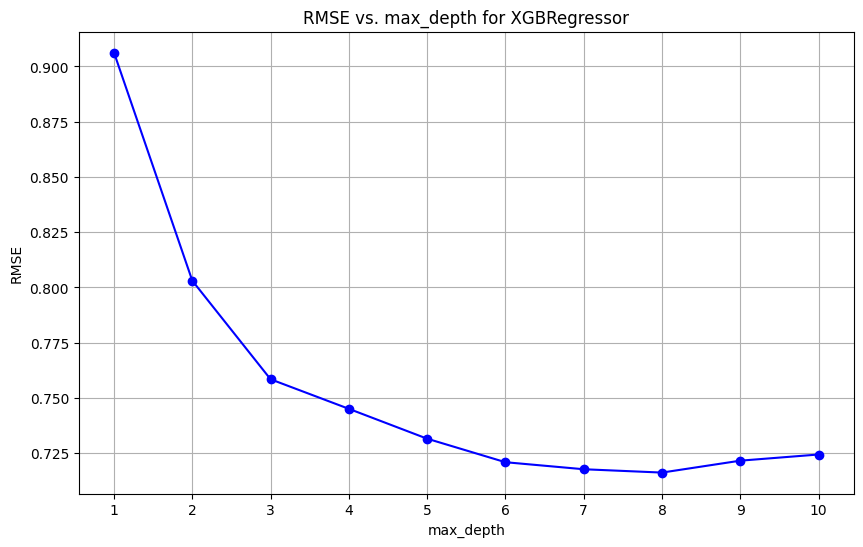

In [92]:
# Define hyperparameters and initialize variables
max_depth_values = range(1, 11)
rmse_values = []

base_params = {
    'reg_alpha': 2.5,
    'n_estimators': 900,
    'learning_rate': 0.03,
    'grow_policy': 'depthwise',
    'objective': 'reg:squarederror',
    'random_state': 42,
    'verbosity': 0
}

# Train models and compute RMSE for each max_depth
for depth in max_depth_values:
    params = base_params.copy()
    params['max_depth'] = depth
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)
    print(f"max_depth={depth}, RMSE={rmse:.4f}")

# Plot RMSE vs. max_depth
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE vs. max_depth for XGBRegressor')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.xticks(max_depth_values)
plt.grid(True)
plt.show()